In [1]:
%%bash

echo -e "C-alpha\nC-alpha\n" | gmx covar \
  -s step5_1.tpr \
  -f step5_1_fit.xtc \
  -o eigenval.xvg \
  -v eigenvec.trr \
  -xpma covar_atom.xpm
gmx xpm2ps -f covar_atom.xpm -o covar_atom.eps
# gmx xpm2ps -f covar_atom.xpm -o covar_atom.eps -di my.m2p

                      :-) GROMACS - gmx covar, 2025.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/fridrichmethod/data/repos/mdpp/assets/3
Command line:
  gmx covar -s step5_1.tpr -f step5_1_fit.xtc -o eigenval.xvg -v eigenvec.trr -xpma covar_atom.xpm

Reading file step5_1.tpr, VERSION 2025.2 (single precision)
Reading file step5_1.tpr, VERSION 2025.2 (single precision)
Group     0 (         System) has 84458 elements
Group     1 (        Protein) has  4994 elements
Group     2 (      Protein-H) has  2457 elements
Group     3 (        C-alpha) has   319 elements
Group     4 (       Backbone) has   957 elements
Group     5 (      MainChain) has  1275 elements
Group     6 (   MainChain+Cb) has  1558 elements
Group     7 (    MainChain+H) has  1579 elements
Group     8 (      SideChain) has  3415 elements
Group     9 (    SideChain-H) has  1182 elements
Group    10 (    Prot-Masses) has  4994 elements
Group    11 (    non-Protein) has 


Choose a group for the least squares fit
Selected 3: 'C-alpha'

Choose a group for the covariance analysis
Selected 3: 'C-alpha'


                      :-) GROMACS - gmx xpm2ps, 2025.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/fridrichmethod/data/repos/mdpp/assets/3
Command line:
  gmx xpm2ps -f covar_atom.xpm -o covar_atom.eps

                 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 9 9 9 9 9 9 910There is 1 matrix in covar_atom.xpm
Matrix 0 is 319 x 319
Auto tick spacing for X-axis: major 50, minor 10
Auto tick spacing for Y-axis: major 50, minor 10

GROMACS reminds you: "I Used To Care, But Things Have Changed" (Bob Dylan)



Set the x-size of the box to 1.254
Set the y-size of the box to 1.254
Selected legend of matrix # 0 for display
for display


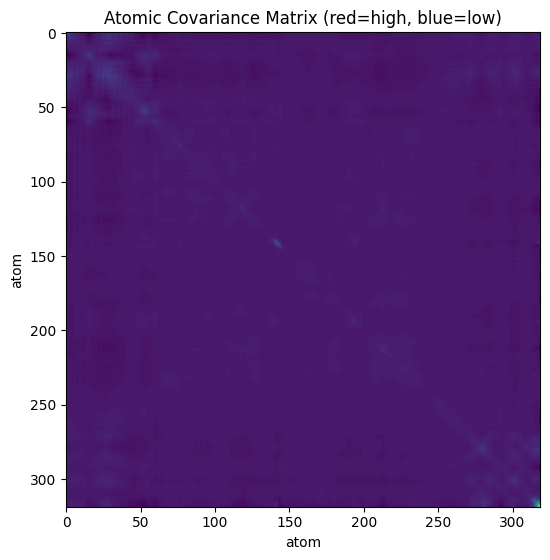

Matrix shape: (319, 319) min: -0.0649 max: 0.902 centered at 0: True


In [ ]:
# Plot covariance matrix from GROMACS XPM (covar_atom.xpm)
# Requirements from user:
# - Use a red–blue diverging palette similar to the original, with red = high variance, blue = low variance
# - Input: covar_atom.xpm
# - Outputs: PNG and PDF figures
#
# Implementation notes:
# - Robust XPM parser (handles chars-per-pixel > 1; reads numeric values from /* "value" */ when present).
# - Flips vertically so that (0,0) is at lower-left (GROMACS XPM first data row is top row).
# - Uses a diverging colormap ('coolwarm'); if both positive and negative values exist, center the color scale at 0
#   (so negative covariance -> blue, positive -> red). If all values are >= 0, uses linear scaling.
# - Does NOT smooth or resample; shows the true matrix values.
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from pathlib import Path

xpm_path = Path("covar_atom.xpm")
assert xpm_path.exists(), "File not found: covar_atom.xpm"

text = xpm_path.read_text(encoding="utf-8", errors="ignore")
lines = text.splitlines()

# ---- Parse header (width, height, ncolors, chars-per-pixel) ----
hdr_re = re.compile(r'^\s*"?\s*(\d+)\s+(\d+)\s+(\d+)\s+(\d+)')
width = height = ncolors = cpp = None
hdr_idx = None
for i, ln in enumerate(lines):
    m = hdr_re.search(ln)
    if m:
        width, height, ncolors, cpp = map(int, m.groups())
        hdr_idx = i
        break
assert hdr_idx is not None, "Invalid XPM header"

color_start = hdr_idx + 1
color_lines = lines[color_start : color_start + ncolors]


def extract_symbol_and_value(cline, cpp):
    # symbol is first cpp chars of the quoted payload
    m = re.search(r'"([^"]+)"', cline)
    sym = m.group(1)[:cpp] if m else cline.strip().rstrip(",")[:cpp]
    # numeric label inside /* "..." */
    m2 = re.search(r'/\*\s*"?\s*([+-]?(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+-]?\d+)?)\s*"?\s*\*/', cline)
    val = float(m2.group(1)) if m2 else None
    return sym, val


# Build color mapping
color_index_map = {}
color_val_map = {}
numeric_labels_present = True
for idx, cl in enumerate(color_lines):
    sym, val = extract_symbol_and_value(cl, cpp)
    color_index_map[sym] = idx
    color_val_map[sym] = val
    if val is None:
        numeric_labels_present = False

# Optional meta: axis labels/ticks (if present in XPM)
legend_title = None
x_label = "Atom index"
y_label = "Atom index"
for ln in lines[:hdr_idx]:
    m = re.search(r'legend:\s*"([^"]+)"', ln, flags=re.I)
    if m:
        legend_title = m.group(1)
    m = re.search(r'x-label:\s*"([^"]+)"', ln, flags=re.I)
    if m:
        x_label = m.group(1)
    m = re.search(r'y-label:\s*"([^"]+)"', ln, flags=re.I)
    if m:
        y_label = m.group(1)

# ---- Collect pixel matrix rows ----
matrix_rows = []
target_len = width * cpp
for ln in lines[color_start + ncolors :]:
    for m in re.finditer(r'"([^"]+)"', ln):
        s = m.group(1)
        if len(s) == target_len:
            matrix_rows.append(s)
    if len(matrix_rows) == height:
        break
assert len(matrix_rows) == height, f"Expected {height} rows, got {len(matrix_rows)}"

# ---- Build numeric matrix ----
M = np.empty((height, width), float)
for i, row in enumerate(matrix_rows):
    tokens = [row[j : j + cpp] for j in range(0, target_len, cpp)]
    for j, tok in enumerate(tokens):
        v = color_val_map.get(tok, None)
        M[i, j] = (
            v if (numeric_labels_present and v is not None) else float(color_index_map.get(tok, 0))
        )

# Flip vertically to Cartesian orientation (lower-left origin)
M = np.flipud(M)

# Decide normalization: if both signs appear, center at 0
vmin, vmax = float(np.nanmin(M)), float(np.nanmax(M))
use_centered = (vmin < 0.0) and (vmax > 0.0)

plt.figure(figsize=(6.8, 5.7))

if use_centered:
    norm = TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
    im = plt.imshow(M, origin="lower", interpolation="nearest", cmap="coolwarm", norm=norm)
else:
    im = plt.imshow(
        M, origin="lower", interpolation="nearest", cmap="coolwarm", vmin=vmin, vmax=vmax
    )

# cbar = plt.colorbar(im)
# cbar.set_label(legend_title or "Covariance (Å²)")

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title("Atomic Covariance Matrix (red=high, blue=low)")
plt.tight_layout()
plt.savefig("covar_atom_heatmap.png", dpi=300)
plt.savefig("covar_atom_heatmap.pdf")
plt.show()

print("Matrix shape:", M.shape, "min:", vmin, "max:", vmax, "centered at 0:", use_centered)


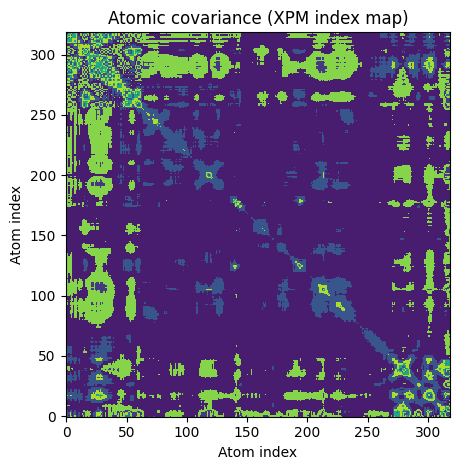

In [2]:
# 读取 GROMACS .xpm 为矩阵并作图（不依赖外部脚本）
import pathlib
import re

import matplotlib.pyplot as plt
import numpy as np


def load_xpm(path):
    with pathlib.Path(path).open("r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()
    # 提取头信息：宽w、高h、字符数nchars、每像素字符宽pixchars
    hdr = [l for l in lines if re.search(r"^\s*\"?\d+\s+\d+\s+\d+\s+\d+", l)]
    w, h, nchars, pixchars = map(int, re.findall(r"\d+", hdr[0])[:4])
    # 找到调色表（这里 xpm 中的颜色值我们不使用，只取“字符→数值”的顺序）
    # 对 GROMACS 生成的 xpm，数据行通常紧随配色表之后，以引号括的 ASCII 图阵为主
    # 简化：直接把字符映射为整数索引
    data_lines = []
    seen = 0
    for l in lines:
        if (
            l.strip().startswith('"')
            and l.strip().endswith('",')
            and len(l.split()[0].strip('"')) >= w * pixchars
        ):
            payload = l.strip().strip('",')
            if len(payload) >= w * pixchars:
                data_lines.append(payload[: w * pixchars])
                seen += 1
                if seen == h:
                    break
    A = np.zeros((h, w), dtype=int)
    for i, row in enumerate(data_lines):
        for j in range(w):
            A[i, j] = hash(row[j * pixchars : (j + 1) * pixchars]) & 0xFFFFFFFF
    # 由于 xpm2ps 使用色阶映射，绝对值无所谓；这里只做可视化
    return A


M = load_xpm("covar_atom.xpm")
plt.figure()
plt.imshow(M, origin="lower", interpolation="nearest")
plt.title("Atomic covariance (XPM index map)")
plt.xlabel("Atom index")
plt.ylabel("Atom index")
plt.tight_layout()
plt.savefig("covar_atom.pdf")


In [3]:
%%bash

# PC1：时间 与 投影值
echo -e "C-alpha\nC-alpha\n" | gmx anaeig -v eigenvec.trr -s step5_1.tpr -f step5_1_fit.xtc \
  -first 1 -last 1 -proj pc1.xvg

# PC2：时间 与 投影值
echo -e "C-alpha\nC-alpha\n" | gmx anaeig -v eigenvec.trr -s step5_1.tpr -f step5_1_fit.xtc \
  -first 2 -last 2 -proj pc2.xvg

                      :-) GROMACS - gmx anaeig, 2025.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/fridrichmethod/data/repos/mdpp/assets/3
Command line:
  gmx anaeig -v eigenvec.trr -s step5_1.tpr -f step5_1_fit.xtc -first 1 -last 1 -proj pc1.xvg

trr version: GMX_trn_file (single precision)
Read non mass weighted reference structure with 319 atoms from eigenvec.trr
Read non mass weighted average/minimum structure with 319 atoms from eigenvec.trr
Read 957 eigenvectors (for 319 atoms)

Reading file step5_1.tpr, VERSION 2025.2 (single precision)
Reading file step5_1.tpr, VERSION 2025.2 (single precision)
Group     0 (         System) has 84458 elements
Group     1 (        Protein) has  4994 elements
Group     2 (      Protein-H) has  2457 elements
Group     3 (        C-alpha) has   319 elements
Group     4 (       Backbone) has   957 elements
Group     5 (      MainChain) has  1275 elements
Group     6 (   MainChain+Cb) has  1558 e


Select the index group that was used for the least squares fit in gmx covar
Selected 3: 'C-alpha'

Select an index group of 319 elements that corresponds to the eigenvectors
Selected 3: 'C-alpha'



                      :-) GROMACS - gmx anaeig, 2025.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/fridrichmethod/data/repos/mdpp/assets/3
Command line:
  gmx anaeig -v eigenvec.trr -s step5_1.tpr -f step5_1_fit.xtc -first 2 -last 2 -proj pc2.xvg

trr version: GMX_trn_file (single precision)
Read non mass weighted reference structure with 319 atoms from eigenvec.trr
Read non mass weighted average/minimum structure with 319 atoms from eigenvec.trr
Read 957 eigenvectors (for 319 atoms)

Reading file step5_1.tpr, VERSION 2025.2 (single precision)
Reading file step5_1.tpr, VERSION 2025.2 (single precision)
Group     0 (         System) has 84458 elements
Group     1 (        Protein) has  4994 elements
Group     2 (      Protein-H) has  2457 elements
Group     3 (        C-alpha) has   319 elements
Group     4 (       Backbone) has   957 elements
Group     5 (      MainChain) has  1275 elements
Group     6 (   MainChain+Cb) has  1558 e


Select the index group that was used for the least squares fit in gmx covar
Selected 3: 'C-alpha'

Select an index group of 319 elements that corresponds to the eigenvectors
Selected 3: 'C-alpha'

Select an index group of 319 elements that corresponds to the eigenvectors
Selected 3: 'C-alpha'



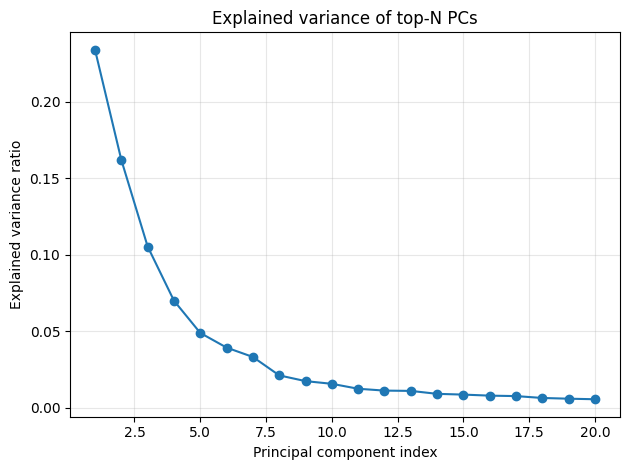

In [5]:
import matplotlib.pyplot as plt

# 读取并合并（跳过 xvg 注释行）
pc1 = np.loadtxt("pc1.xvg", comments=("#", "@", "&"))
pc2 = np.loadtxt("pc2.xvg", comments=("#", "@", "&"))

# 严格对齐时间列
assert pc1.shape[0] == pc2.shape[0]
assert np.allclose(pc1[:, 0], pc2[:, 0])

pc12 = np.c_[pc1[:, 0], pc1[:, 1], pc2[:, 1]]
# 写成 xvg（含简单头注释，gmx sham 会忽略 @/# 开头行）
with pathlib.Path("pc12_time.xvg").open("w") as f:
    f.write('@ title "PC1 & PC2 vs time"\n')
    f.write('@ xaxis  label "Time (ps)"\n')
    f.write('@ yaxis  label "PCs"\n')
    f.writelines(f"{t:.6f} {p1:.6f} {p2:.6f}\n" for t, p1, p2 in pc12)

# 读取特征值，绘制前 N 个主成分占比
lam = np.loadtxt("eigenval.xvg", comments=("#", "@"))
lam = lam[:, 1] if lam.ndim == 2 else lam
ratio = lam / lam.sum()
N = min(20, ratio.size)  # 你可自行调整
plt.figure()
plt.plot(np.arange(1, N + 1), ratio[:N], marker="o")
plt.xlabel("Principal component index")
plt.ylabel("Explained variance ratio")
plt.title("Explained variance of top-N PCs")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("pca_variance_topN.pdf")


In [ ]:
%%bash

# 二维 FES（PC1, PC2）。确保输入是 .xvg 且包含“时间 + 两列 y 值”
gmx sham -f pc12_time.xvg \
  -tsham 310.15 \
  -ngrid 100 \
  -nlevels 100 \
  -pmin 1e-6 \
  -ls FES_pc12.xpm \
  -lp PROB_pc12.xpm \
  -histo HIST_pc12.xvg \
  -g sham.log

# 转为矢量图
gmx xpm2ps -f FES_pc12.xpm -o FES_pc12.eps


                       :-) GROMACS - gmx sham, 2025.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/fridrichmethod/data/repos/mdpp/assets/3
Command line:
  gmx sham -f pc12_time.xvg -tsham 310.15 -ngrid 100 -nlevels 100 -ls FES_pc12.xpm -lp PROB_pc12.xpm -histo HIST_pc12.xvg -g sham.log

         1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7 7 7 7 8 8 8 8 8 9 9 9 9 910         1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7 7 7 7 8 8 8 8 8 9 9 9 9 910         1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7 7 7 7 8 8 8 8 8 9 9 9 9 910         1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7 7 7 7 8 8 8 8 8 9 9 9 9 910
GROMACS reminds you: "Confirmed" (Star Trek)



Read 2 sets of 13774 points, dt = 100

There are 10000 bins in the 2-dimensional histogram. Beta-Emin = 0
Ptot = 13774


                      :-) GROMACS - gmx xpm2ps, 2025.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/fridrichmethod/data/repos/mdpp/assets/3
Command line:
  gmx xpm2ps -f FES_pc12.xpm -o FES_pc12.eps

         1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7 7 7 7 8 8 8 8 8 9 9 9 9 910There is 1 matrix in FES_pc12.xpm
Matrix 0 is 100 x 100
Auto tick spacing failed for X-axis, guessing 1.14702
Auto tick spacing for X-axis: major 1.14702, minor 0.229404
Auto tick spacing failed for Y-axis, guessing 0.9866
Auto tick spacing for Y-axis: major 0.9866, minor 0.19732

GROMACS reminds you: "Confirmed" (Star Trek)



Set the x-size of the box to 4.000
Set the y-size of the box to 4.000
Selected legend of matrix # 0 for display
for display


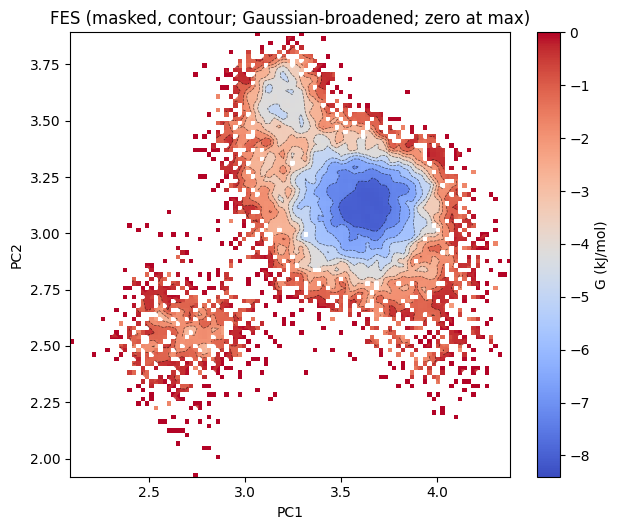

Matrix: (100, 100) Observed fraction: 0.2973
F range (after shift): -8.40146576669893 0.0


In [ ]:
# Enhanced FES plotting from GROMACS XPM:
# - Mask unsampled bins (set to white; only plot meaningful values)
# - Add filled contours and contour lines
# - Smooth via Gaussian broadening (mask-aware)
# - Set zero of free energy at the *maximum* (as requested)
#
# Inputs:
#   FES_pc12.xpm
# Outputs:
#   FES_pc12_masked_contours.png
#   FES_pc12_masked_contours.pdf
#   FES_pc12_masked_values.npy
#
# Notes:
# - Unsampled bins are inferred as those at the global maximum in the XPM
#   (common in gmx sham outputs when a bin has zero counts). A small tolerance
#   is used to be robust.
# - Gaussian smoothing preserves masked holes via normalized convolution:
#       smooth(M*mask) / smooth(mask)
#   If SciPy is unavailable, falls back to no smoothing.
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

xpm_path = Path("FES_pc12.xpm")
text = xpm_path.read_text(encoding="utf-8", errors="ignore")
lines = text.splitlines()

# ---- Parse header ----
hdr_re = re.compile(r'^\s*"?\s*(\d+)\s+(\d+)\s+(\d+)\s+(\d+)')
width = height = ncolors = cpp = None
hdr_idx = None
for i, ln in enumerate(lines):
    m = hdr_re.search(ln)
    if m:
        width, height, ncolors, cpp = map(int, m.groups())
        hdr_idx = i
        break

color_start = hdr_idx + 1
color_lines = lines[color_start : color_start + ncolors]


def extract_symbol_and_value(cline, cpp):
    m = re.search(r'"([^"]+)"', cline)
    sym = m.group(1)[:cpp] if m else cline.strip().rstrip(",")[:cpp]
    m2 = re.search(r'/\*\s*"?\s*([+-]?(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+-]?\d+)?)\s*"?\s*\*/', cline)
    val = float(m2.group(1)) if m2 else None
    return sym, val


# Build color maps
color_index_map = {}
color_val_map = {}
numeric_labels_present = True
for idx, cl in enumerate(color_lines):
    sym, val = extract_symbol_and_value(cl, cpp)
    color_index_map[sym] = idx
    color_val_map[sym] = val
    if val is None:
        numeric_labels_present = False

# Meta
legend_title = None
x_label = None
y_label = None
x_ticks = None
y_ticks = None
for ln in lines[:hdr_idx]:
    m = re.search(r'legend:\s*"([^"]+)"', ln, flags=re.IGNORECASE)
    if m:
        legend_title = m.group(1)
    m = re.search(r'x-label:\s*"([^"]+)"', ln, flags=re.IGNORECASE)
    if m:
        x_label = m.group(1)
    m = re.search(r'y-label:\s*"([^"]+)"', ln, flags=re.IGNORECASE)
    if m:
        y_label = m.group(1)

for ln in lines[color_start + ncolors : color_start + ncolors + 100]:
    if "x-axis:" in ln:
        nums = re.findall(r"([+-]?\d+(?:\.\d+)?)", ln)
        if nums:
            x_ticks = np.array([float(u) for u in nums], float)
    if "y-axis:" in ln:
        nums = re.findall(r"([+-]?\d+(?:\.\d+)?)", ln)
        if nums:
            y_ticks = np.array([float(u) for u in nums], float)

# Matrix rows
matrix_rows = []
target_len = width * cpp
for ln in lines[color_start + ncolors :]:
    for m in re.finditer(r'"([^"]+)"', ln):
        s = m.group(1)
        if len(s) == target_len:
            matrix_rows.append(s)
    if len(matrix_rows) == height:
        break

# Build numeric matrix
M = np.empty((height, width), float)
for i, row in enumerate(matrix_rows):
    tokens = [row[j : j + cpp] for j in range(0, target_len, cpp)]
    for j, tok in enumerate(tokens):
        v = color_val_map.get(tok)
        if numeric_labels_present and (v is not None):
            M[i, j] = v
        else:
            M[i, j] = float(color_index_map.get(tok, 0))

# Flip vertically to Cartesian orientation
M = np.flipud(M)

# Extent
if x_ticks is not None and x_ticks.size > 0:
    x_min, x_max = float(np.min(x_ticks)), float(np.max(x_ticks))
else:
    x_min, x_max = 0.0, float(width)
if y_ticks is not None and y_ticks.size > 0:
    y_min, y_max = float(np.min(y_ticks)), float(np.max(y_ticks))
else:
    y_min, y_max = 0.0, float(height)
extent = [x_min, x_max, y_min, y_max]

# ---- Mask unsampled bins: treat max value bins as "unsampled" ----
vmax = float(np.nanmax(M))
tol = max(1e-9, 1e-6 * vmax)
mask_obs = np.abs(M - vmax) > tol  # observed if not equal to global max
# If everything is marked observed (rare), relax criterion by using top 1% as unsampled
if mask_obs.mean() > 0.99:
    thr = np.quantile(M, 0.99)
    mask_obs = thr + tol > M

# ---- Gaussian smoothing with mask-aware normalization ----
smoothed = M.copy()
try:
    from scipy.ndimage import gaussian_filter

    sigma = 0.8  # adjust as needed
    num = gaussian_filter(M * mask_obs, sigma=sigma, mode="nearest")
    den = gaussian_filter(mask_obs.astype(float), sigma=sigma, mode="nearest")
    with np.errstate(invalid="ignore", divide="ignore"):
        smoothed = num / np.clip(den, 1e-8, None)
        smoothed[~mask_obs] = np.nan  # keep holes as NaN
except Exception:
    # No SciPy; fall back to raw values
    smoothed[~mask_obs] = np.nan

# ---- Shift zero to maximum (so max -> 0) ----
finite_vals = smoothed[np.isfinite(smoothed)]
if finite_vals.size:
    max_obs = float(np.nanmax(finite_vals))
else:
    max_obs = vmax
F = smoothed - max_obs  # now F <= 0 everywhere; highest becomes 0

# Save numeric
np.save("FES_pc12_masked_values.npy", F)

# ---- Plot with white holes and contours ----
import matplotlib
from matplotlib.colors import ListedColormap

base_cmap = plt.get_cmap("coolwarm")  # blue low, red high
# Make a copy with NaN/Masked color = white
new_cmap = base_cmap.copy()
new_cmap.set_bad(color="white")

plt.figure(figsize=(6.4, 5.4))

# Filled image
im = plt.imshow(F, origin="lower", extent=extent, aspect="auto", cmap=new_cmap)

# Filled contours only over valid data
# Choose contour levels spanning observed range; since F<=0, we can use negative levels up to 0
if finite_vals.size:
    fmin, fmax = float(np.nanmin(F)), float(np.nanmax(F))  # fmax should be 0
    levels = np.linspace(fmin, 0.0, 12)  # 12 levels from min to zero
    # Build grid for contour coordinates
    ny, nx = F.shape
    xs = np.linspace(x_min, x_max, nx)
    ys = np.linspace(y_min, y_max, ny)
    X, Y = np.meshgrid(xs, ys)
    # Contourf with masked array
    F_ma = np.ma.masked_invalid(F)
    cf = plt.contourf(X, Y, F_ma, levels=levels, cmap=new_cmap, alpha=0.85, antialiased=True)
    # Contour lines
    c = plt.contour(X, Y, F_ma, levels=levels, colors="k", linewidths=0.5, alpha=0.6)

# Colorbar
cbar = plt.colorbar(im)
cbar.set_label(legend_title or "ΔG (shifted, max = 0)")

plt.xlabel(x_label or "PC1")
plt.ylabel(y_label or "PC2")
plt.title("FES (masked, contour; Gaussian-broadened; zero at max)")
plt.tight_layout()
plt.savefig("FES_pc12_masked_contours.png", dpi=300)
plt.savefig("FES_pc12_masked_contours.pdf")
plt.show()

print("Matrix:", M.shape, "Observed fraction:", float(mask_obs.mean()))
print("F range (after shift):", float(np.nanmin(F)), float(np.nanmax(F)))


In [8]:
%%bash

echo -e "Backbone\nBackbone" | gmx rms -s step5_1_complex_fit.pdb -f step5_1_fit.xtc -o rmsd_bb.xvg
echo -e "Protein\nProtein"  | gmx gyrate -s step5_1.tpr -f step5_1_fit.xtc -o gyrate.xvg


                       :-) GROMACS - gmx rms, 2025.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/fridrichmethod/data/repos/mdpp/assets/3
Command line:
  gmx rms -s step5_1_complex_fit.pdb -f step5_1_fit.xtc -o rmsd_bb.xvg

Select group for least squares fit
Group     0 (         System) has  4994 elements
Group     1 (        Protein) has  4994 elements
Group     2 (      Protein-H) has  2457 elements
Group     3 (        C-alpha) has   319 elements
Group     4 (       Backbone) has   957 elements
Group     5 (      MainChain) has  1275 elements
Group     6 (   MainChain+Cb) has  1558 elements
Group     7 (    MainChain+H) has  1579 elements
Group     8 (      SideChain) has  3415 elements
Group     9 (    SideChain-H) has  1182 elements
Select a group: Select group for RMSD calculation
Group     0 (         System) has  4994 elements
Group     1 (        Protein) has  4994 elements
Group     2 (      Protein-H) has  2457 elements



         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

Selected 4: 'Backbone'
Selected 4: 'Backbone'


                      :-) GROMACS - gmx gyrate, 2025.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/fridrichmethod/data/repos/mdpp/assets/3
Command line:
  gmx gyrate -s step5_1.tpr -f step5_1_fit.xtc -o gyrate.xvg

Reading file step5_1.tpr, VERSION 2025.2 (single precision)
Reading file step5_1.tpr, VERSION 2025.2 (single precision)
Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/fridrichmethod/data/repos/mdpp/assets/3
Command line:
  gmx gyrate -s step5_1.tpr -f step5_1_fit.xtc -o gyrate.xvg

Reading file step5_1.tpr, VERSION 2025.2 (single precision)
Reading file step5_1.tpr, VERSION 2025.2 (single precision)
Reading frame   13000 time 1300000.000   
Analyzed 13774 frames, last time 1377300.000

GROMACS reminds you: "It is an unfortunate fact that when you raise the question of the reliability of many simulations you are often told about how much manpower went into it, how large & fas

In [9]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np

# 读取并合并（跳过 xvg 注释行）
pc1 = np.loadtxt("rmsd_bb.xvg", comments=("#", "@", "&"))
pc2 = np.loadtxt("gyrate.xvg", comments=("#", "@", "&"))

# 严格对齐时间列
assert pc1.shape[0] == pc2.shape[0]
assert np.allclose(pc1[:, 0], pc2[:, 0])

pc12 = np.c_[pc1[:, 0], pc1[:, 1], pc2[:, 1]]
# 写成 xvg（含简单头注释，gmx sham 会忽略 @/# 开头行）
with pathlib.Path("pc12_time.xvg").open("w") as f:
    f.write('@ title "PC1 & PC2 vs time"\n')
    f.write('@ xaxis  label "Time (ps)"\n')
    f.write('@ yaxis  label "PCs"\n')
    f.writelines(f"{t:.6f} {p1:.6f} {p2:.6f}\n" for t, p1, p2 in pc12)

In [10]:
%%bash

gmx sham -f pc12_time.xvg \
  -tsham 310.15 \
  -ngrid 100 \
  -nlevels 100 \
  -ls FES_pc12.xpm \
  -lp PROB_pc12.xpm \
  -histo HIST_pc12.xvg \
  -g sham.log

# 转为矢量图
gmx xpm2ps -f FES_pc12.xpm -o FES_pc12.eps

                       :-) GROMACS - gmx sham, 2025.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/fridrichmethod/data/repos/mdpp/assets/3
Command line:
  gmx sham -f pc12_time.xvg -tsham 310.15 -ngrid 100 -nlevels 100 -ls FES_pc12.xpm -lp PROB_pc12.xpm -histo HIST_pc12.xvg -g sham.log


Back Off! I just backed up ener.xvg to ./#ener.xvg.1#

Back Off! I just backed up bindex.ndx to ./#bindex.ndx.1#

Back Off! I just backed up sham.log to ./#sham.log.1#

Back Off! I just backed up PROB_pc12.xpm to ./#PROB_pc12.xpm.1#
         1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7 7 7 7 8 8 8 8 8 9 9 9 9 910
Back Off! I just backed up FES_pc12.xpm to ./#FES_pc12.xpm.1#
         1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7 7 7 7 8 8 8 8 8 9 9 9 9 910
Back Off! I just backed up enthalpy.xpm to ./#enthalpy.xpm.1#
         1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7 7 7 7 8 8 8 8 8 9 9 9 9 9

Read 2 sets of 13774 points, dt = 100

There are 10000 bins in the 2-dimensional histogram. Beta-Emin = 0
Ptot = 13774


                      :-) GROMACS - gmx xpm2ps, 2025.2 (-:

Executable:   /usr/local/gromacs/bin/gmx
Data prefix:  /usr/local/gromacs
Working dir:  /home/fridrichmethod/data/repos/mdpp/assets/3
Command line:
  gmx xpm2ps -f FES_pc12.xpm -o FES_pc12.eps

         1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 7 7 7 7 7 8 8 8 8 8 9 9 9 9 910There is 1 matrix in FES_pc12.xpm
Matrix 0 is 100 x 100
Auto tick spacing failed for X-axis, guessing 0.0510898
Auto tick spacing for X-axis: major 0.0510898, minor 0.010218
Auto tick spacing failed for Y-axis, guessing 19.1726
Auto tick spacing for Y-axis: major 19.1726, minor 3.83453

Back Off! I just backed up FES_pc12.eps to ./#FES_pc12.eps.1#

GROMACS reminds you: "Pretend That You're Hercule Poirot" (TeX)



Set the x-size of the box to 4.000
Set the y-size of the box to 4.000
Selected legend of matrix # 0 for display
for display


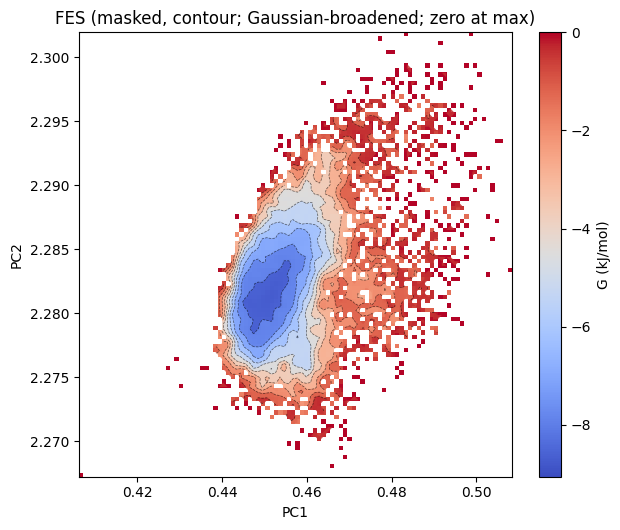

Matrix: (100, 100) Observed fraction: 0.2319
F range (after shift): -9.061016293569526 0.0


In [12]:
# Enhanced FES plotting from GROMACS XPM:
# - Mask unsampled bins (set to white; only plot meaningful values)
# - Add filled contours and contour lines
# - Smooth via Gaussian broadening (mask-aware)
# - Set zero of free energy at the *maximum* (as requested)
#
# Inputs:
#   FES_pc12.xpm
# Outputs:
#   FES_pc12_masked_contours.png
#   FES_pc12_masked_contours.pdf
#   FES_pc12_masked_values.npy
#
# Notes:
# - Unsampled bins are inferred as those at the global maximum in the XPM
#   (common in gmx sham outputs when a bin has zero counts). A small tolerance
#   is used to be robust.
# - Gaussian smoothing preserves masked holes via normalized convolution:
#       smooth(M*mask) / smooth(mask)
#   If SciPy is unavailable, falls back to no smoothing.
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

xpm_path = Path("FES_pc12.xpm")
text = xpm_path.read_text(encoding="utf-8", errors="ignore")
lines = text.splitlines()

# ---- Parse header ----
hdr_re = re.compile(r'^\s*"?\s*(\d+)\s+(\d+)\s+(\d+)\s+(\d+)')
width = height = ncolors = cpp = None
hdr_idx = None
for i, ln in enumerate(lines):
    m = hdr_re.search(ln)
    if m:
        width, height, ncolors, cpp = map(int, m.groups())
        hdr_idx = i
        break

color_start = hdr_idx + 1
color_lines = lines[color_start : color_start + ncolors]


def extract_symbol_and_value(cline, cpp):
    m = re.search(r'"([^"]+)"', cline)
    sym = m.group(1)[:cpp] if m else cline.strip().rstrip(",")[:cpp]
    m2 = re.search(r'/\*\s*"?\s*([+-]?(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+-]?\d+)?)\s*"?\s*\*/', cline)
    val = float(m2.group(1)) if m2 else None
    return sym, val


# Build color maps
color_index_map = {}
color_val_map = {}
numeric_labels_present = True
for idx, cl in enumerate(color_lines):
    sym, val = extract_symbol_and_value(cl, cpp)
    color_index_map[sym] = idx
    color_val_map[sym] = val
    if val is None:
        numeric_labels_present = False

# Meta
legend_title = None
x_label = None
y_label = None
x_ticks = None
y_ticks = None
for ln in lines[:hdr_idx]:
    m = re.search(r'legend:\s*"([^"]+)"', ln, flags=re.IGNORECASE)
    if m:
        legend_title = m.group(1)
    m = re.search(r'x-label:\s*"([^"]+)"', ln, flags=re.IGNORECASE)
    if m:
        x_label = m.group(1)
    m = re.search(r'y-label:\s*"([^"]+)"', ln, flags=re.IGNORECASE)
    if m:
        y_label = m.group(1)

for ln in lines[color_start + ncolors : color_start + ncolors + 100]:
    if "x-axis:" in ln:
        nums = re.findall(r"([+-]?\d+(?:\.\d+)?)", ln)
        if nums:
            x_ticks = np.array([float(u) for u in nums], float)
    if "y-axis:" in ln:
        nums = re.findall(r"([+-]?\d+(?:\.\d+)?)", ln)
        if nums:
            y_ticks = np.array([float(u) for u in nums], float)

# Matrix rows
matrix_rows = []
target_len = width * cpp
for ln in lines[color_start + ncolors :]:
    for m in re.finditer(r'"([^"]+)"', ln):
        s = m.group(1)
        if len(s) == target_len:
            matrix_rows.append(s)
    if len(matrix_rows) == height:
        break

# Build numeric matrix
M = np.empty((height, width), float)
for i, row in enumerate(matrix_rows):
    tokens = [row[j : j + cpp] for j in range(0, target_len, cpp)]
    for j, tok in enumerate(tokens):
        v = color_val_map.get(tok)
        if numeric_labels_present and (v is not None):
            M[i, j] = v
        else:
            M[i, j] = float(color_index_map.get(tok, 0))

# Flip vertically to Cartesian orientation
M = np.flipud(M)

# Extent
if x_ticks is not None and x_ticks.size > 0:
    x_min, x_max = float(np.min(x_ticks)), float(np.max(x_ticks))
else:
    x_min, x_max = 0.0, float(width)
if y_ticks is not None and y_ticks.size > 0:
    y_min, y_max = float(np.min(y_ticks)), float(np.max(y_ticks))
else:
    y_min, y_max = 0.0, float(height)
extent = [x_min, x_max, y_min, y_max]

# ---- Mask unsampled bins: treat max value bins as "unsampled" ----
vmax = float(np.nanmax(M))
tol = max(1e-9, 1e-6 * vmax)
mask_obs = np.abs(M - vmax) > tol  # observed if not equal to global max
# If everything is marked observed (rare), relax criterion by using top 1% as unsampled
if mask_obs.mean() > 0.99:
    thr = np.quantile(M, 0.99)
    mask_obs = thr + tol > M

# ---- Gaussian smoothing with mask-aware normalization ----
smoothed = M.copy()
try:
    from scipy.ndimage import gaussian_filter

    sigma = 0.8  # adjust as needed
    num = gaussian_filter(M * mask_obs, sigma=sigma, mode="nearest")
    den = gaussian_filter(mask_obs.astype(float), sigma=sigma, mode="nearest")
    with np.errstate(invalid="ignore", divide="ignore"):
        smoothed = num / np.clip(den, 1e-8, None)
        smoothed[~mask_obs] = np.nan  # keep holes as NaN
except Exception:
    # No SciPy; fall back to raw values
    smoothed[~mask_obs] = np.nan

# ---- Shift zero to maximum (so max -> 0) ----
finite_vals = smoothed[np.isfinite(smoothed)]
if finite_vals.size:
    max_obs = float(np.nanmax(finite_vals))
else:
    max_obs = vmax
F = smoothed - max_obs  # now F <= 0 everywhere; highest becomes 0

# Save numeric
np.save("FES_pc12_masked_values.npy", F)

# ---- Plot with white holes and contours ----

base_cmap = plt.get_cmap("coolwarm")  # blue low, red high
# Make a copy with NaN/Masked color = white
new_cmap = base_cmap.copy()
new_cmap.set_bad(color="white")

plt.figure(figsize=(6.4, 5.4))

# Filled image
im = plt.imshow(F, origin="lower", extent=extent, aspect="auto", cmap=new_cmap)

# Filled contours only over valid data
# Choose contour levels spanning observed range; since F<=0, we can use negative levels up to 0
if finite_vals.size:
    fmin, fmax = float(np.nanmin(F)), float(np.nanmax(F))  # fmax should be 0
    levels = np.linspace(fmin, 0.0, 12)  # 12 levels from min to zero
    # Build grid for contour coordinates
    ny, nx = F.shape
    xs = np.linspace(x_min, x_max, nx)
    ys = np.linspace(y_min, y_max, ny)
    X, Y = np.meshgrid(xs, ys)
    # Contourf with masked array
    F_ma = np.ma.masked_invalid(F)
    cf = plt.contourf(X, Y, F_ma, levels=levels, cmap=new_cmap, alpha=0.85, antialiased=True)
    # Contour lines
    c = plt.contour(X, Y, F_ma, levels=levels, colors="k", linewidths=0.5, alpha=0.6)

# Colorbar
cbar = plt.colorbar(im)
cbar.set_label(legend_title or "ΔG (shifted, max = 0)")

plt.xlabel(x_label or "PC1")
plt.ylabel(y_label or "PC2")
plt.title("FES (masked, contour; Gaussian-broadened; zero at max)")
plt.tight_layout()
plt.savefig("FES_pc12_masked_contours.png", dpi=300)
plt.savefig("FES_pc12_masked_contours.pdf")
plt.show()

print("Matrix:", M.shape, "Observed fraction:", float(mask_obs.mean()))
print("F range (after shift):", float(np.nanmin(F)), float(np.nanmax(F)))


In [ ]:
xtc_path = "step5_1_complex_fit.xtc"
pdb_path = "step5_1_complex_fit.pdb"
temperature = 310.15
R_kJ = 0.008314462618  # kJ/mol/K

# --- load protein-only trajectory
traj = md.load(xtc_path, top=pdb_path)
prot = traj.atom_slice(traj.topology.select("protein"))

# --- backbone torsions (angles in radians)
_, phi = md.compute_phi(prot)  # (n_frames, n_phi)
_, psi = md.compute_psi(prot)  # (n_frames, n_psi)

# periodic embedding: sin/cos to avoid wrap
feat = np.hstack([np.cos(phi), np.sin(phi), np.cos(psi), np.sin(psi)])  # shape (T, D)

# --- choose lag in frames
lag_frames = 50  # 50 * 100 ps = 5 ns

# TICA: request 2 slowest components explicitly
tica = TICA(lagtime=lag_frames, dim=2)  # 'kinetic_map' scaling is default
model = tica.fit(feat).fetch_model()  # fit on raw timeseries; see docs
Z = model.transform(feat)  # (T, 2)
tic1, tic2 = Z[:, 0], Z[:, 1]

# --- 2D histogram -> free energy
nbins = 200
H, xedges, yedges = np.histogram2d(tic1, tic2, bins=nbins, density=True)
with np.errstate(divide="ignore"):
    F = -R_kJ * temperature * np.log(H)
F[np.isinf(F)] = np.nan
F -= np.nanmin(F)

# --- plot
xc = 0.5 * (xedges[:-1] + xedges[1:])
yc = 0.5 * (yedges[:-1] + yedges[1:])
plt.figure(figsize=(6, 5), dpi=160)
plt.imshow(
    F.T,
    origin="lower",
    extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]),
    aspect="auto",
)
cbar = plt.colorbar()
cbar.set_label(r"$\Delta G$ (kJ/mol)")
plt.xlabel("TIC 1")
plt.ylabel("TIC 2")
plt.title("FES in TICA space")
plt.tight_layout()
plt.show()
